In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

In [3]:
plt.style.use('dark_background')

## Cuda tensors

In [4]:
use_cuda = True
cuda = False
# if gpu is to be used
if use_cuda and torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
else:
    device = torch.device("cpu")
print(device)

cpu


## Data loader and samplers

In [5]:
from dataloader import FaceScrubDataset, TripletFaceScrub, SiameseFaceScrub
from dataloader import FaceScrubBalancedBatchSampler

In [6]:
DATA_PATH = 'new_data/'
TRAIN_PATH = 'new_data/train_full_with_ids.txt'
VALID_PATH = 'new_data/val_full_with_ids.txt'
TEST_PATH = 'new_data/test_full_with_ids.txt'

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [8]:
train_df = FaceScrubDataset(txt_file=TRAIN_PATH, root_dir=DATA_PATH, transform=data_transforms['train'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'name': 'Ryan Reynolds', 'person_id': 248, 'gender': 'male', 'face_id': '51878'}
{'name': 'Josie Bissett', 'person_id': 301, 'gender': 'female', 'face_id': '7145'}
{'name': 'Mayim Bialik', 'person_id': 300, 'gender': 'female', 'face_id': '6841'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'name': 'Ashton Kutcher', 'person_id': 22, 'gender': 'male', 'face_id': '4462'}


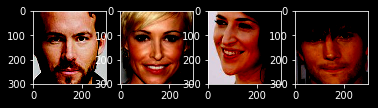

In [9]:
for i in range(4):
    x = np.random.randint(len(train_df))
    img, labels = train_df[x]
    img = img.numpy().transpose((1, 2, 0))
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    print(labels)

In [10]:
triplet_train_df = TripletFaceScrub(train_df, train=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


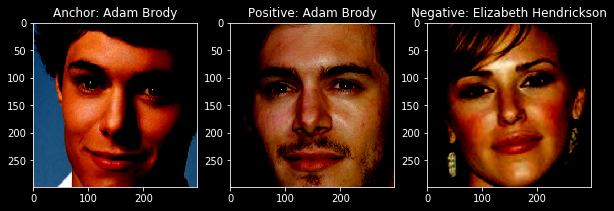

In [11]:
imgs, labels = triplet_train_df[10]

def triplet_images_show(imgs, labels):
    imgs_ = [img.numpy().transpose((1, 2, 0)) for img in imgs]
    plt.figure(figsize=(10, 10))
    plt.subplot(131)
    plt.imshow(imgs_[0])
    plt.title('Anchor: {}'.format(labels[0]['name']))
    plt.subplot(132)
    plt.imshow(imgs_[1])
    plt.title('Positive: {}'.format(labels[1]['name']))
    plt.subplot(133)
    plt.imshow(imgs_[2])
    plt.title('Negative: {}'.format(labels[2]['name']))

triplet_images_show(imgs, labels)

In [12]:
# kwargs = {'num_workers': 1} if cuda else {}

# triplet_batch_sampler = FaceScrubBalancedBatchSampler(dataset=triplet_train_df, n_classes=4, n_samples=10)
# dataloader = torch.utils.data.DataLoader(triplet_train_df, batch_sampler=triplet_batch_sampler, **kwargs)
triplet_dataloader = torch.utils.data.DataLoader(triplet_train_df, batch_size=4, shuffle=True, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
torch.Size([3, 299, 299])
torch.Size([3, 299, 299])
torch.Size([3, 299, 299])
[{'name': ['Kristian Alfonso', 'Russell Crowe', 'James Remar', 'Brendan Fraser'], 'person_id': tensor([ 271,  245,  129,   41]), 'gender': ['female', 'male', 'male', 'male'], 'face_id': ['1056', '51345', '27146', '8723']}, {'name': ['Kristian Alfonso', 'Russell Crowe', 'James Remar', 'Brendan Fraser'], 'person_id': tensor([ 271,  245,  129,   41]), 'gender': ['female', 'male', 'male', 'male'], 'face_id': ['1071', '51294', '27301', '8631']}, {'name': ['Victor Garber', 'Eliza Coupe', 'Robin Williams', 'Caroline Dhavernas'], 'person_id': tensor([ 261,  344,  242,  373]), 'gender': ['male', 'female', 'male', 'female'], 'face_id': ['54949', '16021', '50735', '21577']}]


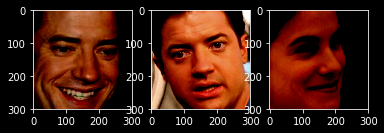

In [13]:
imgs, labels = next(iter(triplet_dataloader))
print(len(imgs))
print(imgs[0][0].shape)
print(imgs[1][0].shape)
print(imgs[2][0].shape)
print(labels)
plt.subplot(131)
plt.imshow(imgs[0][3].numpy().transpose((1, 2, 0)))
plt.subplot(132)
plt.imshow(imgs[1][3].numpy().transpose((1, 2, 0)))
plt.subplot(133)
plt.imshow(imgs[2][3].numpy().transpose((1, 2, 0)))
plt.show()

# plt.imshow(imgs_)
# triplet_images_show(imgs[0][0],labels[0]) 

## Loss function and optimizer criteria

In [14]:
from losses import ContrastiveLoss, TripletLoss, OnlineTripletLoss

In [15]:
from networks import *

In [59]:
inception = models.inception_v3(pretrained=True)
inception.aux_logits = False
num_ftrs = inception.fc.in_features
print(num_ftrs)
# aux_num_ftrs = inception.AuxLogits.in_features
# inception.AuxLogits = InceptionAux(aux_num_ftrs, 128)
inception.fc = torch.nn.Linear(num_ftrs, 128)

2048


In [60]:
tripletinception = TripletNet(inception)

In [61]:
params = list(tripletinception.parameters())
print(len(params))

292


In [66]:
tripletinception.train()

TripletNet(
  (embedding_net): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [67]:
imgs[0].shape

torch.Size([4, 3, 299, 299])

In [68]:
embed1, embed2, embed3 = tripletinception(imgs[0], imgs[1], imgs[2])
print(embed1)

tensor([[ 0.5537,  0.1120, -0.0088, -0.0843, -0.0546, -0.0169, -0.3113,
         -0.0631, -0.2380,  0.1846, -0.0513, -0.3828,  0.6628,  0.1774,
         -0.0955, -0.5643, -0.3377, -0.1318, -0.1469, -0.0646,  0.0160,
          0.1432, -0.3564,  0.2101, -0.3053,  0.3729, -0.1663, -0.4307,
          0.3736, -0.1971, -0.1249,  0.2022,  0.0696, -0.4132,  0.2134,
         -0.2048,  0.1407,  0.3136,  0.2777,  0.0559, -0.0274, -0.4064,
          0.2179, -0.0779,  0.3641, -0.0132, -0.1972, -0.0496,  0.0589,
         -0.0093, -0.2100,  0.2793,  0.2885,  0.0794,  0.0503, -0.0572,
          0.3481, -0.3458,  0.3274,  0.0951, -0.7316, -0.0505, -0.3059,
          0.0898, -0.2041,  0.4850, -0.4100,  0.3187, -0.1275, -0.1468,
         -0.0356,  0.3123,  0.7652, -0.0873, -0.2756, -0.0432, -0.1207,
          0.2073, -0.2354, -0.0801,  0.1734, -0.1924, -0.1794, -0.1562,
          0.2770, -0.4549, -0.1670, -0.1723, -0.1428,  0.4648,  0.2457,
         -0.1420, -0.5289,  0.0499, -0.2071,  0.0380,  0.1896, -

In [69]:
type(embed1)

torch.Tensor

In [70]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [71]:
margin = 1.
criterion = nn.TripletMarginLoss(margin=margin, p=2)

lr = 1e-2
optimizer = optim.Adam(tripletinception.parameters(), lr=lr)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

n_epochs = 1

In [72]:
triplet_dataloader = torch.utils.data.DataLoader(triplet_train_df, batch_size=4, shuffle=True, num_workers=4)
imgs, labels = next(iter(triplet_dataloader))

In [73]:
embed_anchor, embed_pos, embed_neg = tripletinception(imgs[0], imgs[1], imgs[2])



In [75]:
embed_anchor.shape

torch.Size([4, 128])

In [76]:
tripletinception.train()

TripletNet(
  (embedding_net): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [78]:

for epoch in range(n_epochs):
    running_loss = 0.0
    
    for i, (imgs, labels) in enumerate(triplet_dataloader):
        optimizer.zero_grad()
#         print(imgs)
        embed_anchor, embed_pos, embed_neg = tripletinception(imgs[0], imgs[1], imgs[2])
        print(type(embed_anchor))
#         print(embed_anchor)
        
#         print(embed_pos)
#         print(embed_neg)
        loss = criterion(embed_anchor, embed_pos, embed_neg)
        print(loss)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%2 == 0:
            print('{} epoch {} batch: {} loss'.format(epoch, i, running_loss))

print('finished training')


<class 'torch.Tensor'>
tensor(1.0987)
finished training


In [27]:
embed_anchor

(tensor([[ 0.0637,  0.0695, -0.3423,  0.0346,  0.0268, -0.0512, -0.6873,
           0.2984,  0.1961, -0.3168,  0.0414, -0.3899,  0.2598,  0.4208,
           0.0041,  0.6020, -0.0390,  0.4691, -0.3156, -0.1643, -0.1418,
           0.5516,  0.0532,  0.6624,  0.0758,  0.6525, -0.2903, -0.1823,
           0.3883, -0.0214, -0.0824,  0.2176, -0.2043,  0.6631,  0.0377,
           0.1471, -0.1979,  0.1684,  0.5995, -0.2484, -0.6528,  0.5234,
           0.0922,  0.1830,  0.4684, -0.2801, -0.2117,  0.0359,  0.1253,
          -0.6104,  0.7061,  0.1325,  0.2705,  0.1703, -0.0547,  0.1554,
           0.3543, -0.1181, -0.1295,  0.6848, -0.3363, -0.5231,  0.3622,
          -0.0144,  0.2672,  0.4104, -0.5977,  0.3431,  0.1214,  0.1601,
          -0.2193, -0.3104,  0.0253,  0.2803,  0.0446,  0.0510, -0.0218,
          -0.2710,  0.3433, -0.2770, -0.0035, -0.3897,  0.1764, -0.0893,
          -0.0153, -0.4861,  0.2260, -0.0138, -0.0124, -0.5024,  0.2919,
          -0.4178, -0.2508, -0.5268, -0.2336,  0.31